<a href="https://colab.research.google.com/github/kirbah/genai-chaptercraft/blob/main/GenAI_ChapterCraft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

It is running faster with T4 GPU but may slowly work with CPU only.

Define the video URL (change this to any supported video URL).

Youtube videos download is not working due to https://github.com/yt-dlp/yt-dlp/issues/11868

In [59]:
#video_url = "https://www.youtube.com/watch?v=cJuO985zF8E"
video_url = "https://vimeo.com/1013516281"

Install necessary libraries

In [60]:
!pip install -q yt_dlp
!pip install -q transformers
!pip install -q huggingface_hub

Import libraries

In [61]:
import gc
from typing import Any, Dict

import torch
import yt_dlp
from transformers import AutoModelForSpeechSeq2Seq, AutoProcessor, pipeline
from google.colab import userdata
from huggingface_hub import login, InferenceClient

Download video, extract audio and get the filename

In [62]:
def download_audio(url):
    ydl_opts = {
        'format': 'bestaudio/best',
        'postprocessors': [{
            'key': 'FFmpegExtractAudio',
            'preferredcodec': 'mp3',
            'preferredquality': '192',
        }],
    }

    with yt_dlp.YoutubeDL(ydl_opts) as ydl:
        info = ydl.extract_info(url, download=True)
        audio_file = ydl.prepare_filename(info)
        if not audio_file.endswith('.mp3'):
             audio_file = audio_file.rsplit('.', 1)[0] + '.mp3'

    return audio_file

# Download and get the filename.
audio_file = download_audio(video_url)

if audio_file:
  print("Audio file saved as:", audio_file)
else:
  print("Failed to get audio file.")

[vimeo] Extracting URL: https://vimeo.com/1013516281
[vimeo] 1013516281: Downloading webpage


[vimeo] 1013516281: Downloading viewer info
[vimeo] 1013516281: Downloading API JSON
[vimeo] 1013516281: Downloading JSON metadata
[vimeo] 1013516281: Downloading akfire_interconnect_quic m3u8 information
[vimeo] 1013516281: Downloading fastly_skyfire m3u8 information
[vimeo] 1013516281: Downloading akfire_interconnect_quic MPD information


[vimeo] 1013516281: Downloading fastly_skyfire MPD information


[info] 1013516281: Downloading 1 format(s): hls-fastly_skyfire-audio-high-Nederlands
[hlsnative] Downloading m3u8 manifest
[hlsnative] Total fragments: 40
[download] Destination: MyFarys - Ik ben al klant bij Farys [1013516281].mp4
[download] 100% of    5.61MiB in 00:00:02 at 2.49MiB/s                 
[FixupM3u8] Fixing MPEG-TS in MP4 container of "MyFarys - Ik ben al klant bij Farys [1013516281].mp4"
[ExtractAudio] Destination: MyFarys - Ik ben al klant bij Farys [1013516281].mp3
Deleting original file MyFarys - Ik ben al klant bij Farys [1013516281].mp4 (pass -k to keep)
Audio file saved as: MyFarys - Ik ben al klant bij Farys [1013516281].mp3


Prepare to run speach recognition locally using [openai/whisper-large-v3-turbo](https://huggingface.co/openai/whisper-large-v3-turbo) model

In [63]:
if torch.cuda.is_available():
    device = "cuda:0"
    torch_dtype = torch.float16
    model_id = "openai/whisper-large-v3-turbo"
    batch_size = 16
    stride_length_s_tuple = (4, 2)
else:
    device = "cpu"
    torch_dtype = torch.float32
    model_id = "openai/whisper-tiny"
    batch_size = 2
    stride_length_s_tuple = None

model = AutoModelForSpeechSeq2Seq.from_pretrained(
    model_id, torch_dtype=torch_dtype, low_cpu_mem_usage=True, use_safetensors=True
)
model.to(device)

processor = AutoProcessor.from_pretrained(model_id)

pipe = pipeline(
    "automatic-speech-recognition",
    model=model,
    tokenizer=processor.tokenizer,
    feature_extractor=processor.feature_extractor,
    torch_dtype=torch_dtype,
    device=device,
)

Device set to use cpu


Run text recognition, enabling batching and chunking for better result

In [64]:
transcribed_text = pipe(audio_file,
                        chunk_length_s=10,
                        stride_length_s=stride_length_s_tuple,
                        batch_size=batch_size,
                        return_timestamps=True)

/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(
Whisper did not predict an ending timestamp, which can happen if audio is cut off in the middle of a word. Also make sure WhisperTimeStampLogitsProcessor was used during generation.


Result of transcribtion

In [65]:
transcribed_text

{'text': " Open the website www.fareism.de Baby, Pint Faris, Pindee, Can you raise both an and order click and up my Faris? Call me for the ear, up my Faris, and happy there's no Hieno here. Komi volt értat majd fáris, ennáppi de snakén loghin, tanzója értat mutteréj is tréj. Jó húf tédréjztre, hogy már inkét a dolópen. Tának, Je hoeft deze registraatimaar in die het doorlopen. Dan kan je slot aan melden met jou in noggegevens. Registreven is invoordig en kan in en klikklikken. Eerst zou je een kusom te maken tussen ik ben nog geen klant, v ik ben ook klantwever is. Ben je ook klangwefaris. Ben je ook klangwefaris, dan klik je op de onderste knop. Ik ben ook klangwefaris. Dit wil zeggen dat je allen planen over bij ons hebt, dus je hebt dat facturen of priefen met je ook landen maar voor ontvangen van ons. Is dat niet het geval? Klik dan op de knop voorgege en goud dan verder, wie had ik knop ik ben nog hinkland. In CDS kunnen we het gemaakt dan kan je starten met rice rassie. Hier bev

In [66]:
# Clear the GPU cache
torch.cuda.empty_cache()

# Run garbage collection
gc.collect()

9

Convert transript to SRT format

In [67]:
def seconds_to_srt_time(seconds):
    """Convert seconds to SRT time format (HH:MM:SS,mmm)."""
    # Check if seconds is None or not a number
    if seconds is None or not isinstance(seconds, (int, float)):
        return "00:00:00,000"  # Default value for unknown time

    hours = int(seconds // 3600)
    minutes = int((seconds % 3600) // 60)
    secs = int(seconds % 60)
    millis = int((seconds - int(seconds)) * 1000)
    return f"{hours:02}:{minutes:02}:{secs:02},{millis:03}"

def convert_to_srt(transcribed_text):
    """Convert Whisper transcription chunks into SRT format."""
    srt_output = []
    # Check if chunks exist in the result.
    if "chunks" in transcribed_text:
        for i, chunk in enumerate(transcribed_text["chunks"], start=1):
            if chunk.get("timestamp") is not None:
                 start_time = seconds_to_srt_time(chunk["timestamp"][0])
                 end_time = seconds_to_srt_time(chunk["timestamp"][1])
                 srt_output.append(f"{i}\n{start_time} --> {end_time}\n{chunk['text']}\n")
            else:
                 srt_output.append(f"{i}\n{chunk['text']}\n")
        return "\n".join(srt_output)
    else:
        print("No chunks found in transcription. returning plain text")
        return transcribed_text["text"]

# Convert transcript chunks to SRT format
srt_text = convert_to_srt(transcribed_text)

In [68]:
srt_text

"1\n00:00:00,000 --> 00:00:13,669\n Open the website www.fareism.de Baby, Pint Faris, Pindee, Can you raise both an and order click and up my Faris?\n\n2\n00:00:13,669 --> 00:00:16,890\n Call me for the ear, up my Faris, and happy there's no Hieno here. Komi volt értat majd fáris, ennáppi de snakén loghin,\n\n3\n00:00:16,890 --> 00:00:19,390\n tanzója értat mutteréj is tréj.\n\n4\n00:00:19,390 --> 00:00:22,899\n Jó húf tédréjztre, hogy már inkét a dolópen. Tának, Je hoeft deze registraatimaar in die het doorlopen.\n\n5\n00:00:22,899 --> 00:00:26,000\n Dan kan je slot aan melden met jou in noggegevens.\n\n6\n00:00:26,000 --> 00:00:29,629\n Registreven is invoordig en kan in en klikklikken.\n\n7\n00:00:29,629 --> 00:00:33,590\n Eerst zou je een kusom te maken tussen ik ben nog geen klant,\n\n8\n00:00:33,590 --> 00:00:35,329\n v ik ben ook klantwever is. Ben je ook klangwefaris.\n\n9\n00:00:35,329 --> 00:00:39,009\n Ben je ook klangwefaris, dan klik je op de onderste knop.\n\n10\n00:00:39

Login to Hugging Face. Make sure that HF_TOKEN is set in the userdata secrets. New token can be created on the https://huggingface.co/settings/tokens page.

 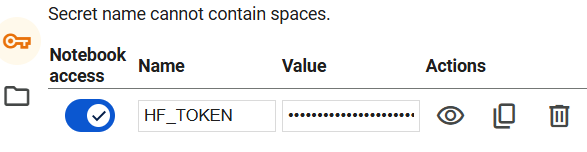

In [69]:
# Get the API token from the user data
huggingface_api_token = userdata.get('HF_TOKEN')

# Check if the HF_TOKEN is set
if huggingface_api_token is None:
    raise ValueError(
        "HF_TOKEN user data variable not set. "
        "Please set it in Colab's."
        "Click on the 'KEY' on the left side"
    )

# Log in using the API token from the HF_TOKEN
login(token=huggingface_api_token)

Generate Chapters

In [70]:
# Replace with your actual model ID
model_id = "Qwen/Qwen2.5-Coder-32B-Instruct"
#model_id = "meta-llama/Llama-3.3-70B-Instruct"

# Create an InferenceClient instance
client = InferenceClient(model=model_id)

# Prepare a prompt with clear instructions on the chapter format
prompt = (
    "Based on the following video transcript, generate a numbered list of concise, SEO-friendly video chapters with timestamps. "
    "Make sure to keep related parts in the single chapter to keep number of chapters smaller. There should be up to 5-10 chapters depending on the video size. "
    "Each chapter should be in the format '<timestamp> <chapter title>', where the first chapter always starts at 0:00. "
    "Timestamps should be in the format 'm:ss' as needed. For example:\n\n"
    "0:00 Intro\n"
    "1:34 Why the GPT wrapper is bad\n"
    "2:14 Smart users workflow\n"
    "\nNothing else except the single Chapters list in the provided format should be generated in the response. Stop generation once you are done with one list.\n"
    "Transcript:\n"
    f"{srt_text}\n\n"
    "Chapters:"
)

# Define the parameters for the text generation request
generation_parameters = {
    "max_new_tokens": 300,  # Maximum length of generated text
    "temperature": 0.5,
    "top_p": 0.95,
    "do_sample": True,
}

# Send the request to the Inference API
generated_text = client.text_generation(prompt, **generation_parameters)

Print result Chapters:

In [72]:
print("Generated Chapters:")
print(generated_text.split("Chapters:")[0] if "Chapters:" in generated_text else generated_text)
print("\nGenerated using free 'GenAI ChapterCraft' tool.")

Generated Chapters:
  
0:00 Introduction to Fareism.de  
1:15 Registration process overview  
2:03 Creating an account  
3:03 Account types  
4:03 Existing customer registration  
5:15 New customer registration  
6:15 Filling out personal information  
7:15 Confirmation email  
8:20 Account activation  
9:07 Logging into the account  
10:07 Account functionalities overview  
11:20 Water meter reading and management  
12:00 Billing and domiciliation requests  
13:00 Water transfer requests  
13:50 Conclusion


Generated using free 'GenAI ChapterCraft' tool.
